In [1]:
import Zygote
using CSV
using DataFrames
using Random
using Lux
using ComponentArrays
using SciMLSensitivity
using DifferentialEquations
using PartialFunctions
using Flux: mse, mae
using Plots
import Optimisers
using StatsBase: sample
using JLD2

rng = Random.default_rng();
include("../../../../population.jl")
include("../../../../callbacks.jl")

basic_tgrad(u,p,t) = zero(u);
S1 = 1

┌ Warning: attempting to remove probably stale pidfile
│   path = /Users/rafaelcuperman/.julia/compiled/v1.10/DifferentialEquations/UQdwS_1oyDd.ji.pidfile
└ @ FileWatching.Pidfile /Users/rafaelcuperman/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244


1

## Data preparation

In [275]:
# Read Data
file = "../../../../data/warfarin.csv"
df = CSV.read(file, DataFrame)
df = df[(df.DVID .== 1), :]

# Create DURATION and RATE columns
df[:, :DURATION] .= ifelse.(df[:, :CMT] .== 1, 1/120, missing) # Set the dose duration to 2 min
df[:, :RATE] .= df[:, :AMT] ./ df[:, :DURATION];

# One dataframe per patient
df_group = groupby(df, :ID);

## Create population

In [276]:
# Create individual
function create_individual(df_individual)
    id = df_individual.ID[1]

    x = Vector{Float64}(df_individual[1, ["WEIGHT", "AGE", "SEX"]]) 
    cols_x = ["WEIGHT", "AGE", "SEX"]

    ty = df_individual[df_individual.MDV .== 0, ["TIME", "DV"]]

    #I = Matrix{Float32}(df_individual[df_individual.MDV .== 1, [:TIME, :AMT, :RATE, :DURATION]])
    I = Matrix{Float32}(df_individual[df_individual.MDV .== 1, [:TIME, :AMT]])
    callback = dose_callback(I; S1 = S1);

    return Individual(id=id, x=x, t=ty.TIME, y=ty.DV, cols_x=cols_x, callback=callback)
end

create_individual (generic function with 1 method)

In [277]:
# Create population
indviduals = Vector(undef, length(df_group))
for (ix, group) in enumerate(df_group)
    indviduals[ix] = create_individual(group)
end
population = Population(indviduals);

## Train

### Functions

In [278]:
# Create neural network architecture. It has input size length(covariates) + dims (u + agumentation)
function dnn(dims, size_x)
    return Chain(
        Dense(dims+size_x, 16, swish),
        Dense(16, 16, swish),
        Dense(16, 8, swish),
        Dense(8, dims)
    ) |> f64
end

# The function received by ODEFunction must have the form f(u, p, t; kwargs...).
# As the neural network receives [u; x] es inputs, we need to wrap the neural network on top of this function with the correct form
function dudt(u, p, t; x, node, st)
    du = node([u; x], p.weights, st)[1] + [p.I; zeros(dims-1)]
    return du
end

# Defines a method for the dudt function that accepts kwargs and calls the original dudt function with those arguments.
# The $ syntax (comes from PartialFunctions) is used to partially apply the function with the provided kwargs
dudt(; kwargs...) = dudt$(; kwargs...)

# Forward pass for one individual (solve the ODE)
function forward(model, individual::Individual, p, st; dudt=dudt, saveat_=get_property(individual, :t), dim_solution=2)
    @ignore_derivatives p.I = zero(p.I)
    u0 = zeros(dims)
    saveat = saveat_
    
    X = copy(get_property(individual, :x))
    X = X ./ [70.0, 40.0, 1.0] # Normalize covariates

    f = dudt(; x = X, node = model, st = st)
    ff = ODEFunction{false}(f; tgrad = basic_tgrad)
    prob = ODEProblem{false}(ff, u0, (-0.1, maximum(saveat_)), p)
    
    sol = solve(prob, Tsit5(),
                saveat = saveat, 
                callback=individual.callback,
                tstops=individual.callback.condition.times,
                sensealg=InterpolatingAdjoint(; autojacvec = ReverseDiffVJP()))

    return sol[dim_solution,:]
end

# Forward pass for list of individuals. The Ref function "freezes" the parameters with respect to the dot operator
forward(model, individuals::Vector{Individual}, p, st; kwargs...) = forward.(Ref(model), individuals, Ref(p), Ref(st); kwargs...)

# Forward pass for population. The Ref function "freezes" the parameters with respect to the dot operator
forward(model, population::Population, p, st; kwargs...) = forward.(Ref(model), population.individuals, Ref(p), Ref(st); kwargs...)


# Loss function
function loss_function(node, individuals, p, st)
    pred = forward(node, individuals, p, st)
    true_values = get_property(individuals, :y)
    return mse(reduce(vcat, true_values), reduce(vcat, pred))
end

# Train one epoch
function train_epoch(individuals, p_)
    global opt_state
    loss, back = Zygote.pullback(p_ -> loss_function(node, individuals, p_, st), p_)
    grad = first(back(1))
    # Detect loss of Inf or NaN. Print a warning, and then skip update
    if !isfinite(loss)
        @warn "loss is $loss"
        return p, loss
    end
    opt_state, p_ = Optimisers.update(opt_state, p_, grad) # Update weights
    return p_, loss # Return updated weights and loss
end

# Train model
function train_model(individuals_train, p_, num_epochs; individuals_test = nothing)

    mae_train = []
    mae_test = []
    mse_train = []
    mse_test = []

    loss = loss_function(node, individuals_train, p_, st)
    println("Epoch 0 -> Loss: $loss")
    
    count = 0
    for epoch in 1:num_epochs
        p_, loss = train_epoch(individuals_train, p_)
        if epoch == 200      
            Optimisers.adjust!(opt_state, 0.001)
        end
        if epoch % 10 == 0 
            println("Epoch $epoch -> Loss: $loss")
        end
        if epoch % 100 == 0
            jldsave("mymodel_checkpoint.jld2"; p_, node)
        end

        # Save MSE and MAE of epoch
        pred_train = forward(node, individuals_train, p_, st)
        true_train = get_property(individuals_train, :y)
        push!(mae_train, mae(reduce(vcat, true_train), reduce(vcat, pred_train)))
        push!(mse_train, mse(reduce(vcat, true_train), reduce(vcat, pred_train)))

        if individuals_test !== nothing
            pred_test = forward(node, individuals_test, p_, st)
            true_test = get_property(individuals_test, :y)
            push!(mae_test, mae(reduce(vcat, true_test), reduce(vcat, pred_test)))
            push!(mse_test, mse(reduce(vcat, true_test), reduce(vcat, pred_test)))
        end

        # Early stopping with patience 10 on MSE train with tolerance 0.01
        if (epoch > 1) && (mse_train[end-1] - mse_train[end] < 0.01)
            count += 1
            if count == 20
                println("Early stopping")
                return p_, mae_train, mse_train, mae_test, mse_test
            end
        else 
            count = 0
        end
    end
    return p_, mae_train, mse_train, mae_test, mse_test
end

function train_fold(population, p, num_epochs)
    # 25% of subjects go to test
    test_ids = sample(1:length(population), div(length(population), 4), replace = false)
    indvs_test = population[test_ids]
    indvs_train = setdiff(population.individuals, indvs_test)

    p, mae_train, mse_train, mae_test, mse_test = train_model(indvs_train, p, num_epochs; individuals_test=indvs_test)

    return p, mae_train[end], mse_train[end], mae_test[end], mse_test[end]
end

function train_kfolds(population, p, folds, num_epochs)
    list_mae_train = Float32[]
    list_mae_test = Float32[]

    for i in 1:folds
        println()
        println("Training fold $i")
        p, mae_train, mse_train, mae_test, mse_test = train_fold(population, p, num_epochs)
        push!(list_mae_train, mae_train)
        push!(list_mae_test, mae_test)
    end
    println()
    println("Mean MAE across all folds - Train: $(mean(list_mae_train))")
    println("Mean MAE across all folds - Test: $(mean(list_mae_test))")
end


train_kfolds (generic function with 1 method)

### Train kfolds

In [366]:
#dims = 4
#
#node = dnn(dims, length(population[1].x))
#ps, st = Lux.setup(Random.default_rng(), node)
#p_ = ComponentVector((weights = ps, I = 0.f0)));
#
#opt = Optimisers.Adam(0.01)
#opt_state = Optimisers.setup(opt, p_);
#loss_function(node, population[1], p_, st)
#
#folds = 1
#num_epochs = 100
#train_kfolds(population, p, folds, num_epochs)

### Train using all the population

In [290]:
### Train with all patients
dims = 3

node = dnn(dims, length(population[1].x))
ps, st = Lux.setup(Random.default_rng(), node)
p_ = ComponentVector((weights = ps, I = 0.f0));

opt = Optimisers.Adam(0.01)
opt_state = Optimisers.setup(opt, p_);
loss_function(node, population[collect(1:10)], p_, st)


8.457005495851817e22

Epoch 0 -> Loss: 8524.12760441135
Epoch 10 -> Loss: 184.77858305164824
Epoch 20 -> Loss: 109.33852006017145
Epoch 30 -> Loss: 364.8813179193275
Epoch 40 -> Loss: 60.60182855865086
Epoch 50 -> Loss: 665.7323443378284
Epoch 60 -> Loss: 688.2485093529864
Epoch 70 -> Loss: 634.3428411159753
Epoch 80 -> Loss: 525.2295425473383
Epoch 90 -> Loss: 398.67716553130384
Epoch 100 -> Loss: 270.5678851158479
Final MAE: 14.170270705455337


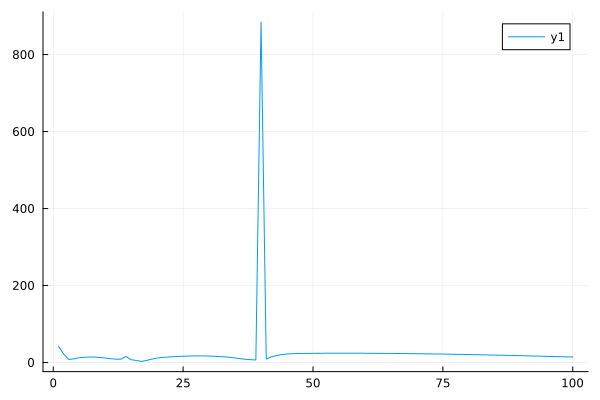

In [280]:
num_epochs = 100
p_final, mae_train, mse_train, mae_test, mse_test = train_model(population[collect(1:10)], p_, num_epochs; individuals_test = nothing)

println("Final MAE: $(mae_train[end])")
plot(mae_train)

In [14]:
# Save model
# jldsave("mymodel.jld2"; p_final, node)

In [ ]:
# Load model
# mymodel = JLD2.load("mymodel.jld2")
# node = mymodel["node"]
# p_final = mymodel["p_final"]


## Predict

### Functions

In [34]:
# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual::Individual, p; plot_predictions=false, dim_solution=2)

    predicted = forward(node, individual, p, st; dim_solution=dim_solution)

    if plot_predictions
        plt = plot(individual.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end
    return predicted
end

# Predict a single real individual with labels. The predicted values are saved for all the times between 0 and max_time but the real labels are plotted for the real times
function predict_real_individual(individual::Individual, p; max_time = 120, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:(max_time-1))
    subject = Individual(; id=individual.id, x=individual.x, t=time, y=zeros(length(time)), 
                        cols_x = ["WEIGHT", "AGE", "SEX"], callback=individual.callback)

    predicted = forward(node, subject, p, st)

    if plot_predictions
        plt = plot(subject.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end

predict_real_individual (generic function with 1 method)

### Predict real individual from population with real labels

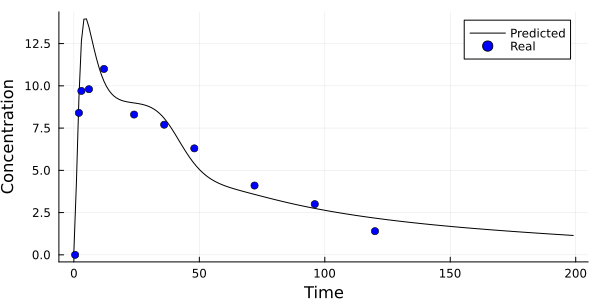

In [264]:
subject = get_individual_by_id(population, 2)

predicted, time = predict_real_individual(subject, p_final; max_time = 200, plot_predictions = true, plot_true_labels = true);

### Predict single individual without labels

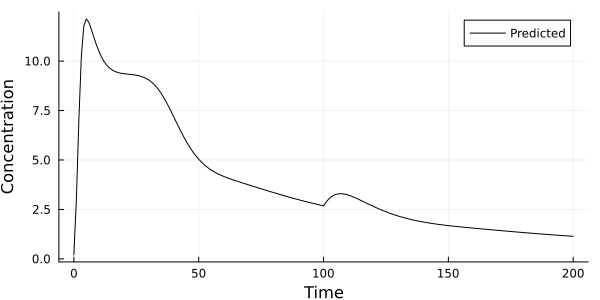

In [273]:
t = collect(0:1:200)
callback = dose_callback([100.0 100.0], S1 = S1)
ind = Individual(id = 999, x = [70.0, 40.0, 1], t = t, y = zeros(length(t)), callback = callback)
predict_individual(ind, p_final; plot_predictions=true, dim_solution = 2);

## Experiments

### Functions

In [34]:
function test_variables(ind, p; max_time=200, variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
    colors = Plots.palette(:viridis, length(values))

    index = findfirst(x -> x == variable, ind.cols_x)

    plt = plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        x = copy(ind.x)
        x[index] = val
        test_ind = Individual(id = ind.id, x = x, t = ind.t, y = ind.y)
        predicted = predict_individual(test_ind, p_final; plot_predictions=false);
        plot!(test_ind.t, predicted, linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)
end

test_variables (generic function with 4 methods)

### Initialize individual

In [35]:
t = collect(0:1:200)
individual = Individual(id = 999, x = [70, 40, 0, 100], t = t, y = zeros(length(t))); # Initialize individual

### Change AMT

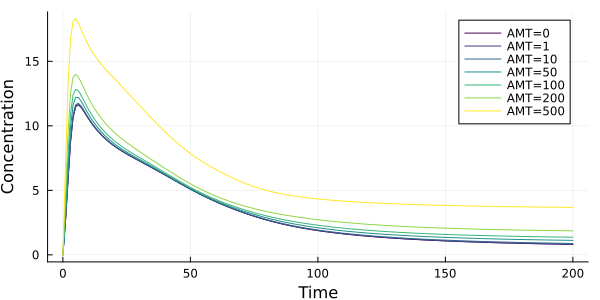

In [36]:
test_variables(individual, p_final; max_time=200, variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])

### Change Weight

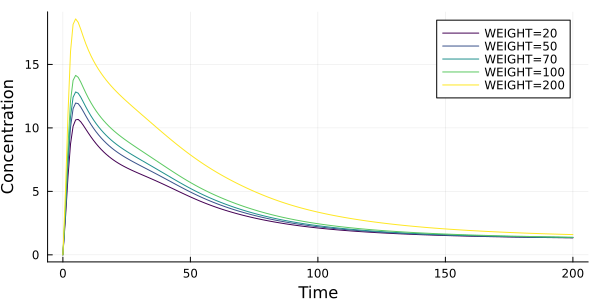

In [37]:
test_variables(individual, p_final; max_time=200, variable="WEIGHT", values=[20, 50, 70, 100, 200])

### Change Age

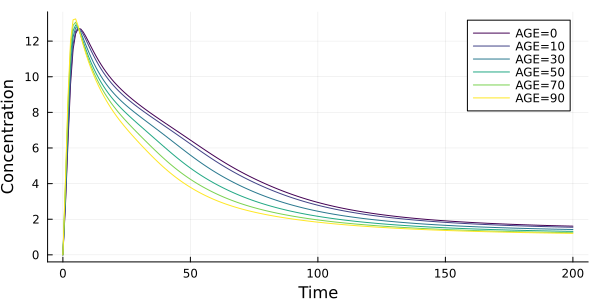

In [38]:
test_variables(individual, p_final; max_time=200, variable="AGE", values=[0, 10, 30, 50, 70, 90])

### Change Sex

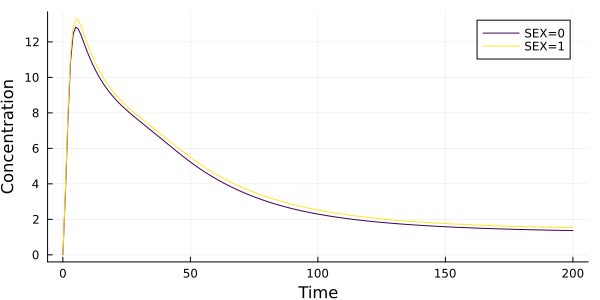

In [39]:
test_variables(individual, p_final; max_time=200, variable="SEX", values=[0, 1])

### Simulate long time

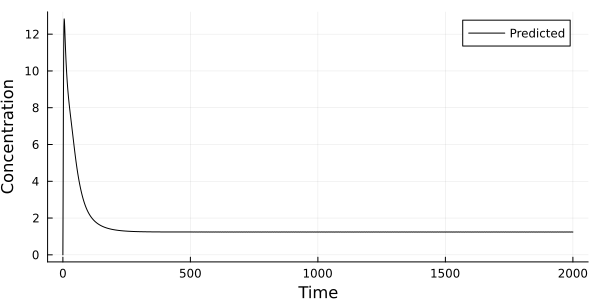

In [40]:
t = collect(0:1:2000)
ind = Individual(id = 999, x = [70, 40, 0, 100], t = t, y = zeros(length(t)))
predict_individual(ind, p_final; plot_predictions = true);